In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from systems_initialization import N_nod, Beta, a, K_nod
from transforms import t_get_O
from transforms import get_split_masks
from transforms import get_pair_split_masks
from transforms import config_RG_masks
from Data import MY_Dataset

normal_dist=torch.distributions.Normal(loc=torch.zeros(N_nod), scale=torch.ones(N_nod))
DS = MY_Dataset(normal_dist,N_nod)
train_loader = DataLoader(DS, batch_size=2**12, shuffle=True)

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(42)

from flows.NormalizingFlow import NormalizingFlow    
from flows.RGflows import RGflows    
from obs import G, calc_Loss, calc_psi2, gen_fun_W




In [4]:
from systems_initialization import osc, anh, morse, tw, columb, rel_osc, rel_morse, rel_tw, rel_columb, ur 

In [5]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters(), **self.optimizer_kwargs)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-5,
            factor=0.95,
            mode="min",
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        sch = self.lr_schedulers()
        sch.step(loss)
        self.log('train_loss', loss,prog_bar=True)
        self.log('lr',sch.get_last_lr()[0],prog_bar=True)
        #print(loss)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [6]:
hidden_dim_dict1={8:8,16:16,32:32,64:64,128:128}
n_flows_dict1={8:6,16:8,32:10,64:10,128:10}
num_hidden_dict1={8:4,16:5,32:6,64:6,128:6}

In [7]:
m = 3
RGmasks = config_RG_masks(m,N_nod)

In [9]:
set_random_seed(42)
rg = RGflows.configure_RG_model(RGmasks,n_flows_dict1,num_hidden_dict1,hidden_dim_dict1,grids_no_grad=0,p_drop=0.0)
filename = "./weights/model_weights_rel_morse.pth"
rg.save(filename)

In [10]:
set_random_seed(42)
rg = RGflows.load_model(filename)
pipeline=Pipeline(model=rg,criterion = rel_morse.get_KL(), optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.001})

trainer = pl.Trainer(
    max_epochs=200,
    logger = TensorBoardLogger(save_dir=f"./logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
rg.save(filename)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\SEVA1\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | RGflows   | 1.9 M  | train
1 | loss  | KL_with_S | 0      | train
--------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.585     Total estimated model params size (MB)
C:\Users\SEVA1\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve 

Training: |                                                                                      | 0/? [00:00<…

C:\Users\SEVA1\anaconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [19]:
RG_trained = RGflows.load_model(filename)
RG_trained.eval()
N_traj=1000
z = normal_dist.sample((N_traj,))
print(z.shape)
with torch.no_grad():
    trajs,_ = RG_trained.g(z)


torch.Size([1000, 256])


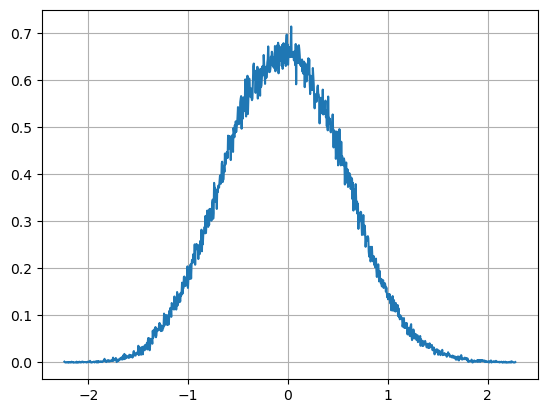

In [25]:
x, P = calc_psi2(trajs)
fig = plt.figure()
plt.plot(x,P)
plt.grid(True)
plt.show()

In [27]:
g_nf=G(trajs)


100%|███████████████████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 157.86it/s]


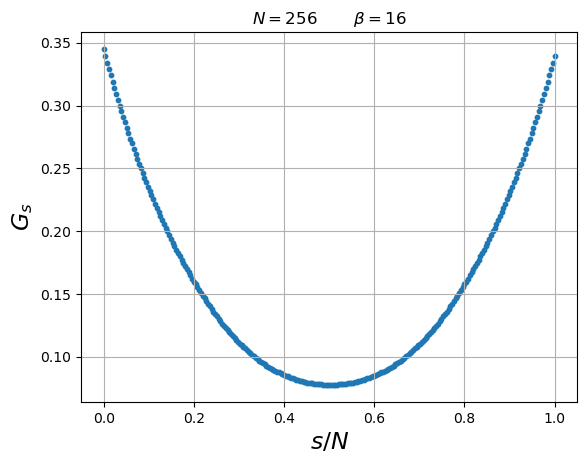

In [28]:
g = g_nf
fig=plt.figure()
plt.scatter(np.linspace(0,1,N_nod),g_nf,s=10)
plt.title(r"$N=$"+str(N_nod)+"       "r"$\beta=$"+str(Beta))
plt.ylabel(r"$G_s$",fontsize=17)
plt.xlabel(r"$s/N$",fontsize=17)
plt.grid(True)
plt.show()
